In [4]:
import pandas as pd
import numpy as np
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from astropy.io import fits
from math import log10

# Database Connection

In [5]:
from src.database.connection import DATABASE_URL

engine = create_engine(DATABASE_URL)
Session = sessionmaker(bind=engine)
session = Session()


# Functions definition

In [6]:
def classify_spectral(teff):
    if teff is None or np.isnan(teff):
        return None
    if teff > 28000:
        return 'O'
    elif 10000 <= teff <= 28000:
        return 'B'
    elif 7500 <= teff < 10000:
        return 'A'
    elif 6000 <= teff < 7500:
        return 'F'
    elif 5200 <= teff < 6000:
        return 'G'
    elif 3700 <= teff < 5200:
        return 'K'
    elif teff < 3700:
        return 'M'
    else:
        return None

In [7]:
def classify_lum_logg(logg):
    """
    Classe de luminosité basée sur logg, en utilisant 
    toute la nomenclature (Ia-O, Ia, Ib, II, III, IV, V, VI, D).
    
    Les seuils sont tirés de principes empiriques et peuvent varier
    selon la métallicité / type spectral. 
    Cf. Gray & Corbally 2009, Morgan & Keenan 1973.
    """
    if logg is None or np.isnan(logg):
        return None

    if logg < 0.0:
        return 'Ia-O'
    elif 0.0 <= logg < 0.5:
        return 'Ia'
    elif 0.5 <= logg < 1.0:
        return 'Ib'
    elif 1.0 <= logg < 1.5:
        return 'II'
    elif 1.5 <= logg < 3.0:
        return 'III'
    elif 3.0 <= logg < 3.5:
        return 'IV'
    elif 3.5 <= logg < 5.0:
        return 'V'
    elif 5.0 <= logg < 7.0:
        return 'VI'
    elif logg >= 7.0:
        return 'D'
    else:
        return None



In [8]:
def classify_lum_j(parallax_mas, j_val):
    """
    Calcule la classe de luminosité via la magnitude absolue M_J,
    si la parallaxe (en mas) et la magnitude apparente J sont disponibles.
    
    Paramètres
    ----------
    parallax_mas : float
        Parallaxe en millisecondes d'arc (mas).
    j_val : float
        Magnitude apparente dans la bande J.

    Renvoie
    -------
    str : la classe de luminosité (Ia-O, Ia, Ib, II, III, IV, V, VI, D) 
          ou None si impossibilité de calcul.
    """
    # Vérifications de base
    if (parallax_mas is None or np.isnan(parallax_mas) or parallax_mas <= 0.0 or
        j_val is None or np.isnan(j_val)):
        return None
    
    # Distance en parsecs
    d_pc = 1000.0 / parallax_mas

    # Magnitude absolue en bande J
    M_j = j_val + 5.0 - 5.0 * np.log10(d_pc)

    # Seuils indicatifs pour les classes de luminosité 
    if M_j <= -9:
        return 'Ia-O'
    elif -9 < M_j <= -7:
        return 'Ia'
    elif -7 < M_j <= -5:
        return 'Ib'
    elif -5 < M_j <= -2:
        return 'II'
    elif -2 < M_j <= 2:
        return 'III'
    elif 2 < M_j <= 4:
        return 'IV'
    elif 4 < M_j <= 9:
        return 'V'
    elif 9 < M_j <= 12:
        return 'VI'
    elif M_j > 12:
        return 'D'
    else:
        return None


In [9]:
import numpy as np

def classify_lum_jhk(parallax_mas, j_val, h_val, k_val):
    """
    Approximation de la classe de luminosité via les 3 bandes J, H, K.
    
    1) Calcule la magnitude absolue dans chaque bande (M_J, M_H, M_K)
       en utilisant la parallaxe (en mas).
    2) Calcule une moyenne (ou "pseudo" magnitude absolue) :
         M_avg = (M_J + M_H + M_K) / 3
    3) Applique des seuils empiriques (Ia-O, Ia, Ib, II, III, IV, V, VI, D).
    
    Paramètres
    ----------
    parallax_mas : float
        Parallaxe en millisecondes d'arc. Doit être > 0 pour calculer une distance.
    j_val, h_val, k_val : float
        Magnitudes apparentes dans les bandes J, H, K.
    
    Renvoie
    -------
    str : la classe de luminosité (Ia-O, Ia, Ib, II, III, IV, V, VI, D)
          ou None si on ne peut pas la déterminer.
    """
    # Vérifications de base : si l'une des valeurs est invalide
    if (parallax_mas is None or parallax_mas <= 0 or np.isnan(parallax_mas) or
        j_val is None or np.isnan(j_val) or
        h_val is None or np.isnan(h_val) or
        k_val is None or np.isnan(k_val)):
        return None

    # Distance en parsecs
    d_pc = 1000.0 / parallax_mas

    # Loi du "distance modulus" : M_lambda = m_lambda + 5 - 5*log10(d)
    M_j = j_val + 5.0 - 5.0 * np.log10(d_pc)
    M_h = h_val + 5.0 - 5.0 * np.log10(d_pc)
    M_k = k_val + 5.0 - 5.0 * np.log10(d_pc)

    # On peut faire la moyenne (Moyenne arithmétique simple)
    M_avg = (M_j + M_h + M_k) / 3.0

    # Seuils indicatifs (varient selon la littérature)
    # Cf. ex.:
    #  - Allen’s Astrophysical Quantities (4th ed.)
    #  - Gray & Corbally 2009
    #  - Morgan & Keenan 1973
    # Adaptés ici à titre d'exemple :
    if M_avg <= -9:
        return 'Ia-O'  # extrêmes supergéantes
    elif -9 < M_avg <= -7:
        return 'Ia'
    elif -7 < M_avg <= -5:
        return 'Ib'
    elif -5 < M_avg <= -2:
        return 'II'
    elif -2 < M_avg <= 2:
        return 'III'
    elif 2 < M_avg <= 4:
        return 'IV'
    elif 4 < M_avg <= 9:
        return 'V'
    elif 9 < M_avg <= 12:
        return 'VI'
    elif M_avg > 12:
        return 'D'
    else:
        return None


# Fetch data

In [10]:
from src.database.creation import DatabaseTables
Star = DatabaseTables.Star

In [11]:
query = session.query(Star).limit(1000000)
results = query.all()

In [12]:
data = []
for star_obj in results:
    row = {
        'apogee_id': star_obj.apogee_id,
        'teff': star_obj.teff,
        'logg': star_obj.logg,
        'j': star_obj.j,
        'h': star_obj.h,
        'k': star_obj.k,
    }
    data.append(row)

df = pd.DataFrame(data)

In [13]:
# load original data : 
hdulist = fits.open('../../data/allStarLite-dr17-synspec_rev1.fits')
hdu1_data = hdulist[1].data
df4 = pd.DataFrame(hdu1_data.tolist(), columns=hdu1_data.names)

In [14]:
# Keep GAIAEDR3_PARALLAX and APOGEE_ID
df4 = df4[['GAIAEDR3_PARALLAX', 'APOGEE_ID']]

In [15]:
# Crossmatch and add parallax to df thanks to APOGEE_ID
df = df.merge(df4, how='left', left_on='apogee_id', right_on='APOGEE_ID')
df.drop(columns='APOGEE_ID', inplace=True)

In [16]:
# only keep rows with non missing values
df = df.dropna()

In [17]:
df.describe()

,teff,logg,j,h,k,GAIAEDR3_PARALLAX
count,673546.000000,673546.000000,673546.000000,673546.000000,673546.000000,673546.000000
mean,4998.064787,3.095578,11.492302,10.750537,10.732557,1.948934
std,1333.710714,1.224553,3.770205,1.431515,3.773796,3.512633
min,3088.049805,-0.473392,5.520000,0.358000,4.856000,-10.957157
25%,4393.051147,2.304122,10.424000,9.882000,9.731000,0.259973
50%,4794.252930,3.003841,11.409000,10.843000,10.700000,0.787476
75%,5203.591919,4.315453,12.381000,11.706000,11.528000,2.522387
max,19863.927734,5.370551,99.999001,99.999001,99.999001,310.577301


# Classification

In [18]:
df['class_spectral'] = df['teff'].apply(classify_spectral)

# descrine spectrla class
df['class_spectral'].value_counts()


class_spectral
K    473163
G    104624
F     43664
M     31492
B     10495
A     10108
Name: count, dtype: int64

In [19]:
df['class_lum_logg'] = df['logg'].apply(classify_lum_logg)

# describe lum logg class
df['class_lum_logg'].value_counts()

class_lum_logg
V       288522
III     257879
IV       48364
II       41215
Ib       29096
Ia        6883
Ia-O      1294
VI         293
Name: count, dtype: int64

In [20]:
df['class_lum_j'] = df.apply(
    lambda x: classify_lum_j(x['GAIAEDR3_PARALLAX'], x['j']),
    axis=1
)

# describe lum j class
df['class_lum_j'].value_counts()

class_lum_j
III     305547
IV      122609
V       121199
II       85276
Ib        9472
Ia        3136
Ia-O      2007
D         1035
VI         331
Name: count, dtype: int64

In [21]:

df['class_lum_h'] = df.apply(
    lambda x: classify_lum_j(x['GAIAEDR3_PARALLAX'], x['h']),
    axis=1
)

# describe lum j class
df['class_lum_h'].value_counts()

class_lum_h
III     289707
IV      129685
II      109915
V        93341
Ib       19683
Ia        5011
Ia-O      3200
VI          69
D            1
Name: count, dtype: int64

In [22]:

df['class_lum_k'] = df.apply(
    lambda x: classify_lum_j(x['GAIAEDR3_PARALLAX'], x['k']),
    axis=1
)

# describe lum j class
df['class_lum_k'].value_counts()

class_lum_k
III     281365
IV      132283
II      116622
V        85582
Ib       23936
Ia        6060
Ia-O      3696
D         1035
VI          33
Name: count, dtype: int64

In [23]:
df['class_lum_jhk'] = df.apply(
    lambda x: classify_lum_jhk(x['GAIAEDR3_PARALLAX'], x['j'], x['h'], x['k']),
    axis=1
)

# describe lum jhk class
df['class_lum_jhk'].value_counts()

class_lum_jhk
III     293980
IV      126211
II      103684
V       101592
Ib       16735
Ia        4422
Ia-O      2878
D         1035
VI          75
Name: count, dtype: int64

In [25]:
# map light classes to numbers

lum_map = {
    'Ia-O': 0,
    'Ia': 1,
    'Ib': 2,
    'II': 3,
    'III': 4,
    'IV': 5,
    'V': 6,
    'VI': 7,
    'D': 8
}

df['class_lum_logg_mapped'] = df['class_lum_logg'].map(lum_map)
df['class_lum_j_mapped'] = df['class_lum_j'].map(lum_map)
df['class_lum_h_mapped'] = df['class_lum_h'].map(lum_map)
df['class_lum_k_mapped'] = df['class_lum_k'].map(lum_map)
df['class_lum_jhk_mapped'] = df['class_lum_jhk'].map(lum_map)



In [26]:
# display number of missing values
df.isnull().sum()

apogee_id                    0
teff                         0
logg                         0
j                            0
h                            0
k                            0
GAIAEDR3_PARALLAX            0
class_spectral               0
class_lum_logg               0
class_lum_j              22934
class_lum_h              22934
class_lum_k              22934
class_lum_jhk            22934
class_lum_logg_mapped        0
class_lum_j_mapped       22934
class_lum_h_mapped       22934
class_lum_k_mapped       22934
class_lum_jhk_mapped     22934
dtype: int64

In [27]:
# drop missing values
df = df.dropna()

In [61]:
# calculate a score for each classification, get a matrix of distance between each classification
#and plot it 



class_lum_logg_mapped    0
class_lum_j_mapped       0
class_lum_h_mapped       0
class_lum_k_mapped       0
class_lum_jhk_mapped     0
dtype: int64
Matrice des distances moyennes entre méthodes :
                       class_lum_logg_mapped  class_lum_j_mapped  \
class_lum_logg_mapped               0.000000            0.537837   
class_lum_j_mapped                  0.537837            0.000000   
class_lum_h_mapped                  0.651908            0.167624   
class_lum_k_mapped                  0.695750            0.212566   
class_lum_jhk_mapped                0.621748            0.117855   

                       class_lum_h_mapped  class_lum_k_mapped  \
class_lum_logg_mapped            0.651908            0.695750   
class_lum_j_mapped               0.167624            0.212566   
class_lum_h_mapped               0.000000            0.058194   
class_lum_k_mapped               0.058194            0.000000   
class_lum_jhk_mapped             0.049836            0.094729   

    

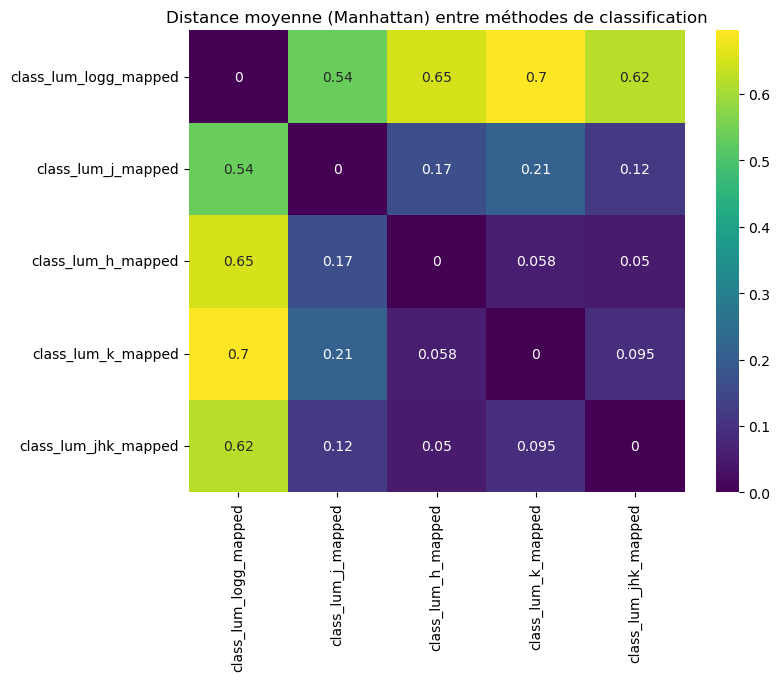

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de colonnes correspondant à 5 méthodes
lum_classes = [
    'class_lum_logg_mapped',
    'class_lum_j_mapped',
    'class_lum_h_mapped',
    'class_lum_k_mapped',
    'class_lum_jhk_mapped'
]

# Vérifier qu'il n'y a pas de valeurs manquantes dans ces colonnes
# (on part du principe que vous avez déjà fait df = df.dropna())
print(df[lum_classes].isnull().sum())

# Initialiser la matrice 5×5
n_methods = len(lum_classes)
distance_matrix = np.zeros((n_methods, n_methods))

# Calcul de la distance moyenne entre chaque paire de méthodes
for i in range(n_methods):
    for j in range(n_methods):
        # Différence absolue entre les deux colonnes, moyennée sur toutes les étoiles
        mean_dist = (df[lum_classes[i]] - df[lum_classes[j]]).abs().mean()
        distance_matrix[i, j] = mean_dist

# Transformer en DataFrame pour facilité d'affichage
dist_df = pd.DataFrame(
    distance_matrix,
    index=lum_classes,
    columns=lum_classes
)

print("Matrice des distances moyennes entre méthodes :")
print(dist_df)

# Heatmap pour visualiser
plt.figure(figsize=(8,6))
sns.heatmap(dist_df, annot=True, cmap='viridis')
plt.title("Distance moyenne (Manhattan) entre méthodes de classification")
plt.show()
